# Table of Contents
* [1. imsitu experiments](#1.-imsitu-experiments)
* [2. parse npc extraction](#2.-parse-npc-extraction)
* [3. simple word list](#3.-simple-word-list)
* [4. MS coco captions](#4.-MS-coco-captions)
	* [4.1 phrases from captions](#4.1-phrases-from-captions)
	* [4.2 parse exp](#4.2-parse-exp)
* [5. german experiments](#5.-german-experiments)
* [6. wordnet](#6.-wordnet)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import pickle
import os
import json
from tqdm import tqdm
from tqdm import tqdm_notebook

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [2]:
from eda import *

# 1. imsitu experiments

In [302]:
icon_list = os.listdir('/Users/schwenk/wrk/pictionary/vision-pictionary/iconary_webgame/public/images/')
icon_list = [i[:-4] for i in icon_list]

In [38]:
out_data_dir = '/Users/schwenk/wrk/pictionary/phrase_gen/sandbox-anikem/out/'

In [39]:
verb_df = pd.read_csv(out_data_dir + 'verbs.txt', header=None, names=['verb'])
situations_df = pd.read_csv(out_data_dir + 'full_situations.txt', header=None, names=['situation'])

situations_df['len'] = situations_df['situation'].apply(lambda x: len(x.split()))
verb_df['len'] = verb_df['verb'].apply(lambda x: len(x))

In [40]:
situations_df.head(1)

,situation,len
0,the person loads a cartridge holder,6


In [41]:
common_verbs = verb_df[verb_df['verb'].apply(lambda x: least_common_word(x))]

In [42]:
common_verbs.head(1)

,verb,len
11,asking,6


In [88]:
# _ = situations_df['len'].hist(bins=12)
# verb_df.sort_values('len')
# ing_verbs = verb_df[verb_df['verb'].str.contains('ing')]

not abstract, easy

In [174]:
description_corpus = ' '.join(situations_df['situation'])

tokenized_corpus = word_tokenize(description_corpus)

normalized_tokens = []
for toke in tokenized_corpus:
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

In [23]:
word_counts = Counter(normalized_tokens)
most_common = word_counts.most_common(200)

In [24]:
filtered_words = [w for w, count in word_counts.items() if count == 1]

In [95]:
sentences = list(set(situations_df['situation'].tolist()))

In [33]:
# sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(sentences))

In [165]:
len(passed_sents) / len(sentences)

0.9645086556406461

In [164]:
len(passed_sents)

59950

In [124]:
with open('./data/unique_parsed_sents.pkl', 'rb') as f:
    unique_parsed_sents = pickle.load(f)

In [136]:
simple_sentences = [sent for sent in unique_parsed_sents if least_common_word(sent, 3.7)]

In [137]:
word_blacklist = set(['uses', 'using', 'people', 'helped', 'measures', 'records', 'data', 'works', 'teach', 'body', 'with', 'training', 'waste', 'plastic', 'gravity', 'commission', 'space'] + colors)

In [138]:
blacklist_removed = [s for s in simple_sentences if not set([w.lower() for w in s.split()]).intersection(word_blacklist)]

In [139]:
len(blacklist_removed)

14050

In [134]:
def filter_on_freq(sent, higher_freq, lower_freq):
    wlfs = [zipf_frequency(w, 'en') for w in sent.split()]
    lowest_freq = min(wlfs)
    return higher_freq > lowest_freq > lower_freq

In [135]:
# freq_filt_words = [t for t in normalized_tokens if filter_on_freq(t, 4.7, 3)]

In [143]:
last_clean = pd.read_csv('tagged_cleaned_sentences_simple.txt', header=None)[0]

In [146]:
chosen_sample = last_clean.apply(lambda x: x.split(' # ')[0]).tolist()

In [181]:
# chosen_sample = blacklist_removed
tagged_sentences = [get_pos_tags(s) for s in chosen_sample]

In [430]:
vocab_complete = list(set(normalized_tokens))
vocab = list(set([w[0].lower() for s in tagged_sentences for w in s if w[1] in ['NN', 'NNS', 'NNP', 'NNPS']]))

In [431]:
voc_ser = pd.Series(vocab)
voc_ser.to_csv('cleaned_sentences_nouns_harder.txt', index=False, header=None)

In [188]:
verbs = []
for s in tagged_sentences:
    for w, tag in s:
        if tag in verb_tags:
            verbs.append(w)
verb_ser = pd.Series(verbs)

nouns = []
for s in tagged_sentences:
    for w, tag in s:
        if tag in noun_tags:
            nouns.append(w)
noun_ser = pd.Series(nouns)

most_common_verbs = verb_ser.value_counts()[1:31]
most_common_nouns = noun_ser.value_counts()[0:30]

In [190]:
u_verbs = pd.Series(pd.unique(verb_ser))

pd.unique(u_verbs.apply(stemmer.stem)).shape

(30,)

In [192]:
all_imsit = ' ' .join(chosen_sample).split()

In [194]:
uv = set(all_imsit)

In [196]:
uvs = pd.Series(list(uv))

In [199]:
pd.unique(uvs.apply(stemmer.stem)).shape

(321,)

In [186]:
pd.unique(u_verbs.apply(stemmer.stem))

array(['work', 'provid', 'is', 'turn', 'attack', 'make', 'give', 'use',
       'stand', 'place', 'measur', 'train', 'lead', 'eat', 'help',
       'drive', 'teach', 'run', 'offer', 'drop', 'play', 'over/through',
       'note', 'handl', 'call', 'rose', 'walk', 'look', 'speak', 'talk'],
      dtype=object)

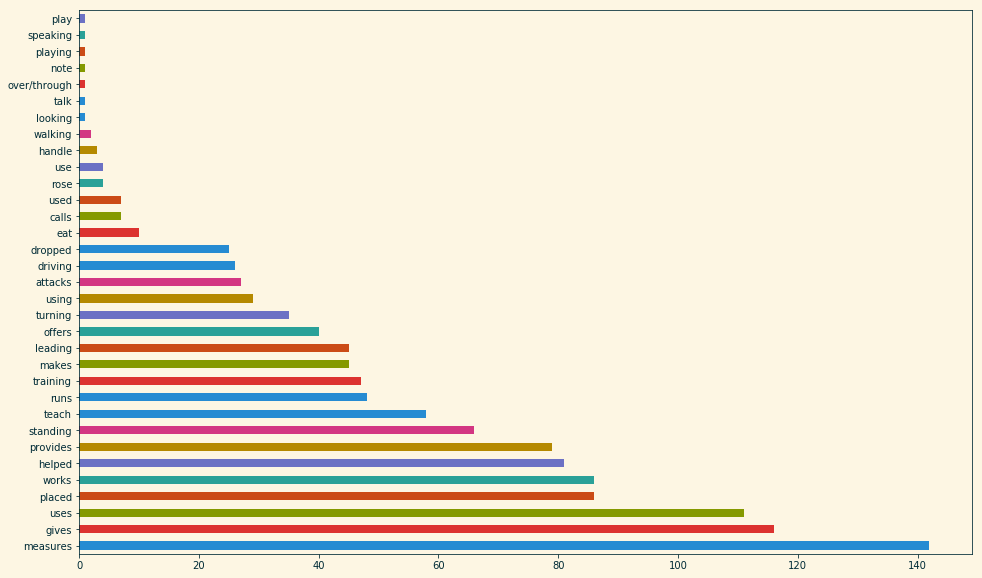

In [189]:
_ = most_common_verbs.plot(kind='barh')

# 2. parse npc extraction

In [46]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
  {<NNP>+}                # chunk sequences of proper nouns
  {<NN>+}                 # chunk consecutive nouns
  """

cp = nltk.RegexpParser(grammar)
# parsed_sent = cp.parse(sent_parses[0])
# for npstr in extract_np(parsed_sent):
#     print (npstr)

# 3. simple word list

In [ ]:
word_data_dir = '/Users/schwenk/wrk/pictionary/BasicEnglishTranslator/data/'

with open('./data/basic_words.csv') as f:
    read_article = f.read()

with open(word_data_dir + 'basic_english.pickle', 'rb') as f:
    all_words = pickle.load(f) 

simple_words = pd.read_csv(word_data_dir + 'basic_english_words.csv')
simple_words.head(1)

# 4. MS coco captions

## 4.1 phrases from captions

In [355]:
with open('/Users/schwenk/wrk/pictionary/coco/annotations/captions_train2014.json') as f:
    coco_captions = json.load(f)

In [356]:
caption_sentences = [c['caption'] for c in coco_captions['annotations']]

In [357]:
len(caption_sentences)

414113

In [358]:
caption_corpus = [w for s in tqdm(caption_sentences) for w in word_tokenize(s)]
# tokenized_corpus = word_tokenize(caption_corpus)

In [359]:
caption_token_set = list(set(caption_corpus))

normalized_tokens = []
for toke in tqdm(caption_corpus):
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

token_counts = Counter(normalized_tokens)

token_counts.most_common(10)

[('man', 51530),
 ('sitting', 36823),
 ('two', 34093),
 ('standing', 30060),
 ('people', 29662),
 ('next', 25916),
 ('white', 25383),
 ('woman', 24220),
 ('table', 21318),
 ('street', 21190)]

In [360]:
len(normalized_tokens)

2397308

In [361]:
cap_df = pd.DataFrame(caption_sentences)
cap_df.columns = ['cap']
cap_df['len'] = cap_df['cap'].str.len()

In [362]:
# _ = cap_df['len'].hist(bins=30)

In [363]:
cap_len_thresh = 30
short_caps = cap_df[cap_df['len'] < 35]

short_cap_l = short_caps['cap'].tolist()

len(short_cap_l)

6051

In [388]:
common_short = [c for c in tqdm(short_cap_l) if least_common_word(c, 2)]
blacklist_removed = [s for s in common_short if not set([w.lower() for w in s.split()]).intersection(set(colors))]
len(blacklist_removed)

5274

In [389]:
sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(blacklist_removed))
passed_sents = [ps for ps in passed_sents if not spellcheck_phrase(ps)]

In [390]:
normed_sents = list(set([normalize_sent(s) for s in passed_sents if 'image' not in s]))

In [391]:
len(normed_sents)

4307

In [392]:
tagged_sentences = [get_pos_tags(s) for s in tqdm(normed_sents)]

In [393]:
sents_w_verbs = [ts[:-1] for ts in tagged_sentences if set([t[1] for t in ts]).intersection(verb_tags)]

In [404]:
# output_sentences(sents_w_verbs)

In [395]:
normed_sents[100:200]

['a guy in a helmet by a clock.',
 'a big clock on a tall building .',
 'a couch with a laptop on it .',
 'a boy feeding a giraffe at a zoo.',
 'a sink and a stove in a kitchen.',
 'a woman and a child are in a room.',
 'a a cupcake on a plate.',
 'a dog sits in front of a car .',
 'a person on the beach with a kite.',
 'a plate with a hot dog and salad.',
 'a bear in the middle of a road.',
 'a fire truck is in a hanger.',
 'a woman and some kids on a bed.',
 'a wall with a clock on it.',
 'a train is on a bridge over water.',
 'a woman using a walker in a home.',
 'a keyboard with a mouse on a desk.',
 'a young man being fed a hot dog.',
 'the cat has it paws on the shoe.',
 'a couple of large buses on a road.',
 'a bus is driven on a city street.',
 'a group of men hang out together .',
 'a train is on a track near water.',
 'a small bus is traveling up hill. .',
 'a cat is in the dirt by a garden.',
 'a couple of meters next to a road.',
 'an old picture of an old man .',
 'a scene

In [376]:
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']

In [396]:
verbs = []
for s in sents_w_verbs:
    for w, tag in s:
        if tag in verb_tags:
            verbs.append(w)
verb_ser = pd.Series(verbs)

nouns = []
for s in sents_w_verbs:
    for w, tag in s:
        if tag in noun_tags:
            nouns.append(w)
noun_ser = pd.Series(nouns)

normalized_tokens = []
for s in tqdm(sents_w_verbs):
    for w in s:
        normalized_tokens.append(w[0])

wcounts = Counter(normalized_tokens)
common = wcounts.most_common(20)

most_common_verbs = verb_ser.value_counts()[1:61]
most_common_nouns = noun_ser.value_counts()[0:60]

In [397]:
lmtzir = WordNetLemmatizer()

In [398]:
stemmer = EnglishStemmer()

In [399]:
all_words = pd.Series(list(set(normalized_tokens)))

In [401]:
pd.unique(all_words.apply(stemmer.stem)).shape

(1038,)

In [403]:
u_verbs = pd.Series(pd.unique(noun_ser))

pd.unique(u_verbs.apply(stemmer.stem)).shape

(679,)

In [ ]:
556 nouns
183 verbs

850 total vocab

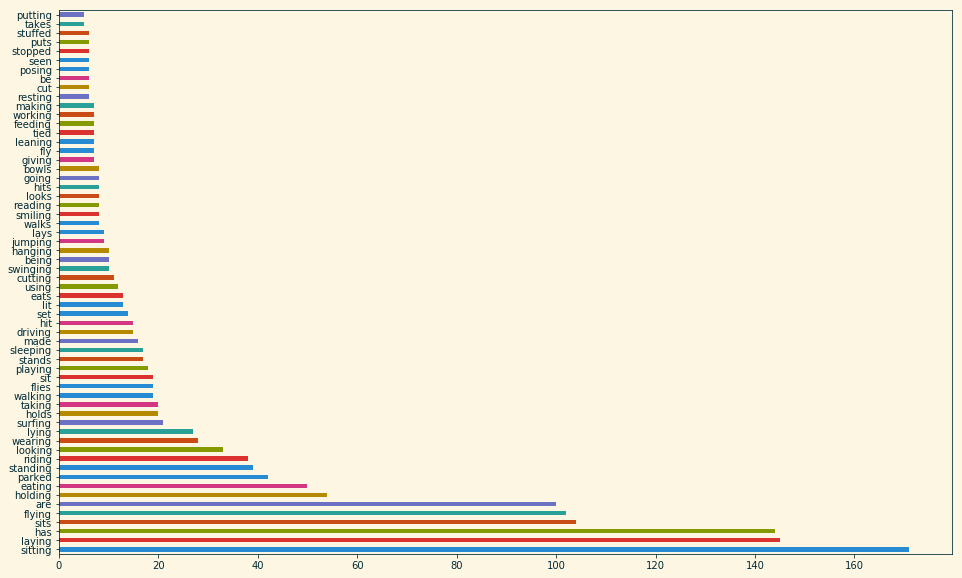

In [153]:
_ = most_common_verbs.plot(kind='barh')

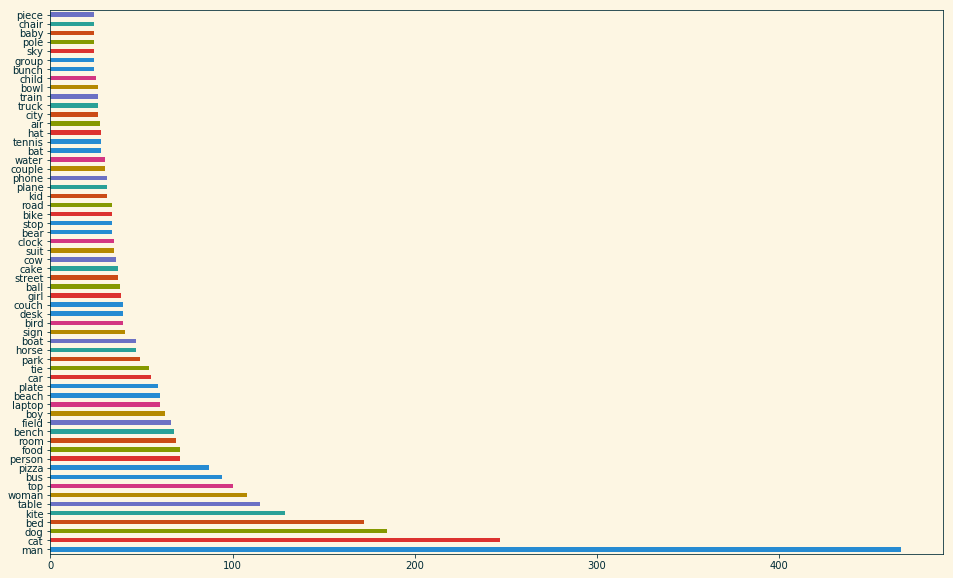

In [154]:
_ = most_common_nouns.plot(kind='barh')

In [23]:
free_words_less = ['a',
 'is',
 'of',
 'the',
 'and',
 'it',
 'are',
#  'that',
 'an']
free_words = ['a',
 'on',
 'is',
 'in',
 'of',
 'the',
 'to',
 'has',
 'at',
 'that',
 'and',
 'it',
 'are',
 'up',
 'with',
 'next',
 'an',]

In [24]:
# with open('sents_w_verbs.pkl', 'wb') as f:
#     pickle.dump(sents_w_verbs, f)

## 4.2 parse exp

In [5]:
with open('sents_w_verbs.pkl', 'rb') as f:
    sents_w_verbs = pickle.load(f)

In [6]:
reformed_sents = [' '.join(w[0] for w in sent) for sent in sents_w_verbs]

a boy is getting on a bus


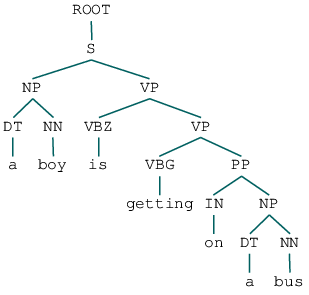

In [26]:
sent = random.choice(reformed_sents)
sent = 'a boy is getting on a bus'
print(sent)
constituent_parse  = [list(i)[0] for i in core_parser.raw_parse_sents([sent])][0]
constituent_parse

_interesting examples_:

a man is in a tie and suit

a cat lying on top of a keyboard

a truck is parked in a lot

the door to a toilet room is open

roses laid on the sheets of a bed

a group of men hang out together

a man flies his kite at a park

a man sits on a bench by himself

a sheep eyes a dog through a fence

a man playing tennis on a hot day

the man is at the table drinking

some items sit next to the door

In [283]:
[s for s in reformed_sents if 'sky' in s and 'plane' in s]

['an airplane is flying in the sky',
 'a plane is flying in the sky',
 'a plane flying high on a clear sky',
 'a plane flying in the sky',
 'a plane is flying up in the sky',
 'the plane is flying up in the sky',
 'a small plane is flying in the sky',
 'a large plane is flying in the sky',
 'a plane is smoking in the sky',
 'a plane flying high up in the sky',
 'a plane flying by on a cloudy sky',
 'a plane is upside down in the sky']

# 5. german experiments

In [468]:
german_words = pd.read_csv('./german_10k.txt', sep=' ', header=None).T
german_words.columns = ['raw_word']

german_words = german_words[german_words['raw_word'].str.isalpha().fillna(False)]

In [472]:
german_words['len'] = german_words.raw_word.str.len()

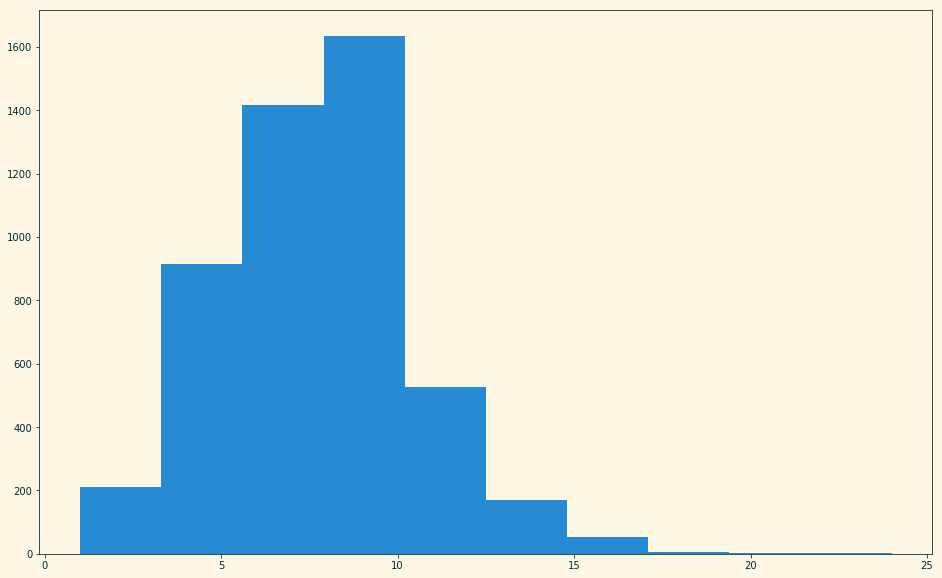

In [475]:
german_words.len.hist()

In [478]:
long_words = german_words[german_words['len'] > 15]

In [485]:
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com',
    ])

In [489]:
to_trans = long_words['raw_word'].tolist()

In [492]:
translations = translator.translate(to_trans, dest='en')

In [498]:
translator.translate('forest fire', dest='de').text

'Waldbrand'

In [506]:
from wiktionaryparser import WiktionaryParser

In [510]:
parser = WiktionaryParser()
word = parser.fetch('test')
another_word = parser.fetch('Aasfresser', 'german')
parser.set_default_language('french')

In [511]:
another_word

[{'definitions': [{'examples': [],
    'partOfSpeech': 'noun',
    'relatedWords': [{'relationshipType': 'synonyms',
      'words': ['Nekrophage']}],
    'text': 'Aasfresser\xa0m (genitive Aasfressers, plural Aasfresser)\nscavenger (an animal that feeds on carrion)\n'}],
  'etymology': 'Aas +\u200e Fresser (from fressen + -er "-er")',
  'pronunciations': {'audio': ['//upload.wikimedia.org/wikipedia/commons/5/52/De-Aasfresser.ogg'],
   'text': ['IPA: /ˈaːsˌfʀɛsɐ/']}}]

# 6. wordnet

In [289]:
easy_words = pd.read_csv('iconary_wordlist_sources/wordlist_easy_aggregated.txt', header=None)

In [291]:
medium_words = pd.read_csv('iconary_wordlist_sources/wordlist_medium_aggregated.txt', header=None)
medium_words = pd.concat([easy_words, medium_words])
medium_words.columns = ['raw_word']
medium_words['word'] = medium_words['raw_word'].str.lower()

In [292]:
medium_words['freq'] = medium_words['word'].apply(lambda x: zipf_frequency(x, 'en'))

In [294]:
# _ = medium_words['freq'].hist(bins=14)

In [295]:
medium_words.shape

(409, 3)

In [296]:
filtered_by_freq = medium_words[medium_words['freq'] > 3]

In [297]:
filtered_by_freq.shape

(348, 3)

In [332]:
 filtered_by_freq['word'].shape

(348,)

In [344]:
expanded_word_list = []
for word in filtered_by_freq['word']:
    sis_words, ssyns = get_word_sisters(word)
    for word in sis_words:
        swf = zipf_frequency(word, 'en')
        if swf > 4 and '-' not in word and word[-3:] != 'ing' and word not in ['bitch', 'delta'] and len(word)>3:
            expanded_word_list.append(word.lower())
exp_ws = set(expanded_word_list)
exp_ws.update(set(filtered_by_freq['word'].tolist()))
expanded_word_list = list(exp_ws.difference(set(icon_list)))

In [346]:
len(expanded_word_list)

576

In [347]:
expanded_word_list

['guard',
 'complex',
 'duration',
 'statue of liberty',
 'drink',
 'source',
 'roll',
 'variation',
 'fate',
 'repair',
 'restoration',
 'baseball',
 'hull',
 'terminal',
 'pump',
 'swimming pool',
 'grab',
 'winter',
 'auto',
 'strip',
 'fur',
 'ridge',
 'arena',
 'game',
 'bracelet',
 'characteristic',
 'bank',
 'beach',
 'mermaid',
 'right',
 'backbone',
 'hybrid',
 'ease',
 'wax',
 'grade',
 'galaxy',
 'arrangement',
 'danger',
 'ways',
 'dark',
 'character',
 'worth',
 'slipper',
 'platform',
 'green',
 'slip',
 'plot',
 'primary',
 'laugh',
 'appearance',
 'member',
 'gear',
 'hood',
 'goodness',
 'distance',
 'commons',
 'country',
 'lift',
 'romance',
 'defense',
 'summer',
 'chin',
 'publicity',
 'force',
 'designer',
 'fairy',
 'times',
 'top hat',
 'ipad',
 'split',
 'knock',
 'impression',
 'refuse',
 'difficulty',
 'circus',
 'uncertainty',
 'ride',
 'carrier',
 'noise',
 'miss',
 'document',
 'chain saw',
 'release',
 'jack',
 'express',
 'pick',
 'silverware',
 'materia

In [ ]:
def form_strings(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = filter_pos_tags(tagged_sentence)
    return f"{' '.join(words)} # {' '.join(include_word)}"


def form_strings_w_pos(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = [w[1] for w in tagged_sentence]
    return f"{' '.join(words)} # {' '.join(include_word)}"

In [423]:
out_lines = []
for word in expanded_word_list:
    n_words = len(word.split())
#     out_s = f"{' '.join(word.split())} # {' '.join(['False'] * n_words)}"
    out_s = f"{' '.join(word.split())} # {' '.join(['NN'] * n_words)}"
    out_lines.append(out_s)

In [424]:
pd.Series(out_lines).to_csv('med_abstract_nouns_pos.txt', index=False)

In [349]:
expanded_word_list

['guard',
 'complex',
 'duration',
 'statue of liberty',
 'drink',
 'source',
 'roll',
 'variation',
 'fate',
 'repair',
 'restoration',
 'baseball',
 'hull',
 'terminal',
 'pump',
 'swimming pool',
 'grab',
 'winter',
 'auto',
 'strip',
 'fur',
 'ridge',
 'arena',
 'game',
 'bracelet',
 'characteristic',
 'bank',
 'beach',
 'mermaid',
 'right',
 'backbone',
 'hybrid',
 'ease',
 'wax',
 'grade',
 'galaxy',
 'arrangement',
 'danger',
 'ways',
 'dark',
 'character',
 'worth',
 'slipper',
 'platform',
 'green',
 'slip',
 'plot',
 'primary',
 'laugh',
 'appearance',
 'member',
 'gear',
 'hood',
 'goodness',
 'distance',
 'commons',
 'country',
 'lift',
 'romance',
 'defense',
 'summer',
 'chin',
 'publicity',
 'force',
 'designer',
 'fairy',
 'times',
 'top hat',
 'ipad',
 'split',
 'knock',
 'impression',
 'refuse',
 'difficulty',
 'circus',
 'uncertainty',
 'ride',
 'carrier',
 'noise',
 'miss',
 'document',
 'chain saw',
 'release',
 'jack',
 'express',
 'pick',
 'silverware',
 'materia

In [354]:
for syn in wordnet.synsets(test_word):
    if syn.pos() != 'n':
        continue
    for hyper in syn.hypernyms():
        for hypo in hyper.hyponyms():
            print(hypo.lemma_names())

Synset('anadama_bread.n.01')
['anadama_bread']
Synset('bap.n.01')
['bap']
Synset('barmbrack.n.01')
['barmbrack']
Synset('breadstick.n.01')
['breadstick', 'bread-stick']
Synset('brown_bread.n.02')
['brown_bread', 'Boston_brown_bread']
Synset('bun.n.01')
['bun', 'roll']
Synset('caraway_seed_bread.n.01')
['caraway_seed_bread']
Synset('challah.n.01')
['challah', 'hallah']
Synset('cinnamon_bread.n.01')
['cinnamon_bread']
Synset('cracked-wheat_bread.n.01')
['cracked-wheat_bread']
Synset('cracker.n.01')
['cracker']
Synset('crouton.n.01')
['crouton']
Synset('dark_bread.n.01')
['dark_bread', 'whole_wheat_bread', 'whole_meal_bread', 'brown_bread']
Synset('english_muffin.n.01')
['English_muffin']
Synset('flatbread.n.01')
['flatbread']
Synset('garlic_bread.n.01')
['garlic_bread']
Synset('gluten_bread.n.01')
['gluten_bread']
Synset('host.n.09')
['Host']
Synset('loaf_of_bread.n.01')
['loaf_of_bread', 'loaf']
Synset('matzo.n.01')
['matzo', 'matzoh', 'matzah', 'unleavened_bread']
Synset('nan.n.04')
['

In [254]:
test_word = 'toast'
sis_words, ssyns = get_word_sisters(test_word)

In [207]:
sis_words

['allamanda',
 'Australian_pea',
 'Dipogon_lignosus',
 'Dolichos_lignosus',
 'Barbados_gooseberry',
 'Barbados-gooseberry_vine',
 'Pereskia_aculeata',
 'bindweed',
 'birthwort',
 'Aristolochia_clematitis',
 'bittersweet',
 'American_bittersweet',
 'climbing_bittersweet',
 'false_bittersweet',
 'staff_vine',
 'waxwork',
 'shrubby_bittersweet',
 'Celastrus_scandens',
 'black-eyed_Susan',
 'black-eyed_Susan_vine',
 'Thunbergia_alata',
 'black_bryony',
 'black_bindweed',
 'Tamus_communis',
 'blue_pea',
 'butterfly_pea',
 'Clitoria_turnatea',
 'Boston_ivy',
 'Japanese_ivy',
 'Parthenocissus_tricuspidata',
 'bougainvillea',
 'bower_actinidia',
 'tara_vine',
 'Actinidia_arguta',
 'bryony',
 'briony',
 'bullbrier',
 'greenbrier',
 'catbrier',
 'horse_brier',
 'horse-brier',
 'brier',
 'briar',
 'Smilax_rotundifolia',
 'butterfly_pea',
 'Clitoria_mariana',
 'butterfly_pea',
 'Centrosema_virginianum',
 'calabar-bean_vine',
 'Physostigma_venenosum',
 'Chinese_gooseberry',
 'kiwi',
 'kiwi_vine',
 

In [565]:
tsns = ssyns[0]

In [640]:
# for syn in wordnet.synsets(test_word):
#     print(syn.definition())